This is a notebook for reviewing the tagged Twitter data for training and evaluating the NLP models for the WEO-Omdena project.

**Author:** Vinzent Steinberg

# Data loading

Upload and read the CSV files we want to analyze.

In [ ]:
from google.colab import files
# Upload the `All_data_sources_merged_updated.csv` from the GitHub repository
twitter_files = files.upload()

Saving All_data_sources_merged_updated.csv to All_data_sources_merged_updated.csv


In [ ]:
import pandas as pd
import io
# It's important to specify the correct encoding of the CSV file. This is something
# we have to know, because it depends on how the file was stored, and the encoding
# is not stored in the CSV file. Nowadays, it is best practise to use UTF-8 for
# everything, but some systems (most famously Windows) still use a different
# encoding, so it's important to be explicit and not rely on the systems default.
d = pd.read_csv(io.BytesIO(twitter_files['All_data_sources_merged_updated.csv']),
                encoding="utf-8")
d['data source'].value_counts()

news article    2465
Instagram       1633
Twitter         1410
Name: data source, dtype: int64

# Data cleaning

Let's make sure that our data is clean. This can be done by looking at the data and see whether there is something unexpected. We will perform the following steps:

1. Make sure there are no duplicate tweets.
2. Make sure the `country` column is consistent. (In principle, this should be done for all categorical columns. Here, it turned out that only the `country` column has problems.)
3. Make sure the `body` column looks good, especially with regards to character encoding. (In our case, this is the only important column containing arbitrary text.)

## Duplicates

In [ ]:
d['body'].duplicated().sum()

0

No duplicates!

There still might be Tweets that are mostly identical or just retweets, but this is tricky to fix at this point.

Let's try sorting the tweets and look for tweets with identical beginnings.

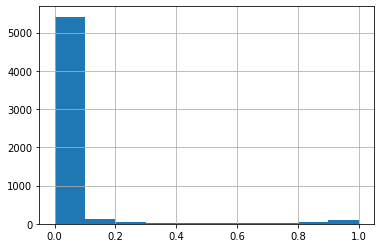

In [ ]:
def check_overlap(a, b):
  overlap = 0
  for i, j in zip(a, b):
    if i == j:
      overlap += 1
    else:
      break
  return overlap

# We need to make sure to sort the texts, so the overlapping texts are next to 
# each other.
sorted = d.sort_values('body')
sorted['overlap'] = None

j_overlap = sorted.columns.get_loc('overlap')

# Calculate the how much the beginning of each text overlaps with the next one.
for i in range(len(sorted) - 1):
  body = sorted['body']
  sorted.iloc[i, j_overlap] = check_overlap(body.iloc[i], body.iloc[i + 1])

# Calculate the ratio of the text overlapping.
sorted['overlap_ratio'] = sorted['overlap'] / sorted['body'].map(len).map(float)

sorted['overlap_ratio'].hist()

The vast majority of texts has very little overlap. We can now look at any pairs of text with more than 50% overlap.

In [ ]:
overlapping = sorted[sorted['overlap_ratio'] > 0.5].index

# Print all pairs of overlapping text.
j_body = sorted.columns.get_loc('body')
compare_first_chars = 300
for idx in overlapping:
  i = sorted.index.get_loc(idx)
  print('vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv')
  print(sorted.iat[i, j_body][:compare_first_chars])
  print('=====================================================')
  print(sorted.iat[i + 1, j_body][:compare_first_chars])
  print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')

vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#DantePH leaves P268.5 million damage to nat'l roads, flood control — DPWH  https://t.co/Y0WVjC8o5m
#DantePH leaves P268.5 million damage to nat'l roads, flood control — DPWH  https://t.co/aJn3y5GBBL
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#FLOODS cause serious damage as system pushes east  https://t.co/ejR17MgoCZ[]
#FLOODS cause serious damage as system pushes east  https://t.co/rwrOOqmlqp #GPWX[]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#FLOODS in France force thousands from their homes  https://t.co/cd1bYJ8jcK #GPWX[]
#FLOODS in France force thousands from their homes  https://t.co/tmiDY55qm3[]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#FLOODS in Maryland and the Carolinas  https://t.co/KfrLCLLifR[]
#FLOODS in Maryland and the Carol

Those are quite a few! They are too similar for training the model. We will get rid of them later.

## `country` column

In [ ]:
d['country'].value_counts()

[]                             976
India                          467
Bhutan                         341
Sri Lanka                      257
Ghana                          223
Jamaica                        199
Australia                      196
Egypt                          193
China                          169
Kenya                          155
Somalia                        138
Vietnam                        107
Nigeria                        102
Pakistan                       101
Afghanistan                     99
Canada                          97
Mozambique                      93
Brazil                          93
Uganda                          88
Iran                            33
Bolivia                         26
Des Moines, Iowa                21
['india']                       11
Cuba                             7
Argentina                        4
['houston']                      3
['california']                   3
['india', 'india', 'india']      1
['southeastasia']   

Some of the values in the `country` column are inconsistent, let's clean them up.

In [ ]:
country_fixes = {
    "[]": None,
    "['india']": "India",
    "['california']": "USA",
    "['june2013']": None,
    "['houston']": "USA",
    "['kenya']": "Kenya",
    "Des Moines, Iowa": "USA",
    "['india', 'india']": "India",
    "['worldasthmaday2021']": None,
    "['southeastasia']": None,
    "Atlantic, IA": "USA",
    "West Des Moines, IA": "USA",
    "Riverside, IA": "USA",
    "Somewhere in Iowa USA": "USA",
    "['india', 'india', 'india']": "India",
    "Cedar Rapids, Iowa": "USA",
    "Des Moines, IA": "USA",
    "Ames, Iowa": "USA",
    "Cedar Rapids": "USA",
}
d['country'].replace(country_fixes).value_counts()

India          480
Bhutan         341
Sri Lanka      257
Ghana          223
Jamaica        199
Australia      196
Egypt          193
China          169
Kenya          156
Somalia        138
Vietnam        107
Nigeria        102
Pakistan       101
Afghanistan     99
Canada          97
Mozambique      93
Brazil          93
Uganda          88
USA             35
Iran            33
Bolivia         26
Cuba             7
Argentina        4
Name: country, dtype: int64

* We fixed all invalid country names. ✔️
* Let's create a new data frame instead of modifying the existing one.
  (This makes it easier to run the notebook cells out of order.)
* For this notebook, we are only interested in the Twitter data, so let's drop all other data sources as well.
* We are also getting rid of the text with the same beginning we detected earlier.

In [ ]:
# Make a new data frame for our modifications
d2 = d.copy()
d2.drop(index=overlapping, inplace=True)
d2['country'] = d['country'].replace(country_fixes)
d2 = d2[d2['data source'] == 'Twitter']

## `body` column

Let's look at 20 random tweets:

In [ ]:
list(d2['body'].sample(20))

['.@EdelmanPR #EarthIsDying Hire me to do big social media &amp; PR if you promise to only work for companies that are helping cool our fun+rad+dying biosphere. So #ClimateChange #Monster #Heatwaves #Wildfires #Floods do not kill 45% of all mc life in 5yr.  https://t.co/pLI4iXSAgO #Love[]',
 "Floods are one of the most common weather dangers in the U.S. Before you find yourself caught in a flood, develop an emergency plan and be prepared to evacuate with your family.  https://t.co/Amap27ICCr #hoppyinsurance #orlandoinsurance #floods #flooding  https://t.co/MhL12wIZUJ['https://pbs.twimg.com/media/E1B0IV8WQAEFDip.jpg']",
 'A 2018 report by the #UnitedNations International Panel on #ClimateChange found that a #warming #climate is responsible for making high mountains more likely to see these kinds of killer #floods and #landslides.[]',
 'The Mapleton community is gathering together and asking for assistance in flood readiness. #Floods #Utah #localnews #Mapleton   https://t.co/r16hi8QHP9[]

Looks good!

* Emojis are displayed correctly, so we got the character encoding right! This would be more important for non-English languages.
* There are some [HTML character entities](https://www.w3schools.com/html/html_entities.asp), like `&amp;`. Ideally, they should be replaced by their Unicode equivalent (e.g. `&` for `&amp;`), because they might cause problems with the NLP models later. This is called "unescaping" and there is a function in the standard library for that. Let's use it!

In [ ]:
import html

print('Before: {} times "&amp;"'.format(d2['body'].map(lambda s: '&amp;' in s).sum()))

d3 = d2.copy()
d3['body'] = d2['body'].map(html.unescape)

print('After: {} times "&amp;"'.format(d3['body'].map(lambda s: '&amp;' in s).sum()))

Before: 142 times "&amp;"
After: 0 times "&amp;"


In [ ]:
list(d3['body'].sample(20))

['@DelRealFoods #1YearToSaveEarth Hire me for sales+social+mktg to help you switch to plant-based 🌽🥑products only to cool our fun+rad+dying biosphere. #ClimateChange #Monster #Heatwaves #Wildfires #Floods may kill 45% of all life in 5 - 6 yrs.  https://t.co/pLI4iXSAgO #Love #Vegan[]',
 "#Forests can be managed to mitigate the negative effects of climate change on water resources and ecosystems, as well as ensure a safe and clean water supply and reduced risk of #floods and #droughts!  https://t.co/Bbh89y8CoU['https://pbs.twimg.com/media/Ezfin1qXsAAUQ3x.jpg']",
 "rt @wef  Flood damage to rise to $32 billion by 2051 - in U.S. alone  https://t.co/nJmQGUC563 #Floods #UnitedStates  https://t.co/GzStyWh1EX['https://pbs.twimg.com/media/E0-LLehXMBAFVNC.png']",
 "4 killed in flash floods in Yemen's historic Tarim city #floods    https://t.co/33eNOohoV2[]",
 "The cost of war is always dear. This is for only those who tasted & understand it's consequences & effects. #Forever for #Peace! We are no

This looks better!

# Data sampling

## Training data for NLP classifiers

We want to make sure our data is representative of real-world data and includes several countries. We also need to make sure our tags are balanced. For this, we have to look at the distribution of the different features first. After that, we will try to get a representative subset of the data.

In [ ]:
d3['country'].value_counts()

Jamaica      194
Australia    137
USA           27
Bolivia       23
India         13
Cuba           7
Argentina      4
Kenya          1
Name: country, dtype: int64

As we so above, our Twitter data set has a strong bias towards Jamaica and Australia. Unfortunately, we don't have a lot of data available from other countries, so this will be tricky to fix without creating a new data set.

Let's also see how many tweets are not assigned to a country.

In [ ]:
print('{}/{} tweets without country'.format(d3['country'].isna().sum(), len(d3)))

834/1240 tweets without country


That's the majority by far. Not much we can do about this. 🤷

Let's also look at the distribution of tags.

In [ ]:
d3['category'].value_counts()

none                 646
flood                523
drought               42
flood_and_drought     29
Name: category, dtype: int64

**The good news:** We have about as many tweets about disasters as tweets about something else! This is well balanced.

**The bad news:** There is not a lot of tweets about droughts. One "trick" is to use the `flood_and_drought` tweets as `drought` tweets to get more data.

The [original plan](https://docs.google.com/document/d/1T-M0vwf9Xq5AYMlO6a1qPueqtnVfs0lNvlLFTMldjMY/edit?usp=sharing) was to get 200 tweets for each tag (`none`, `flood`, `drought`), but there is not that many tweets for droughts. We will just have to use all that is available.

To make the random samples reproducible, we will explicitely manage the state of the random number generator.

**Why not use all available tweets?** We want to avoid to have biased training data, so it's good to avoid having a lot of tweets from the same time period, about the same event, or from the same user. The easiest way to do that is to take a random subset, because this way it is unlikely to have a lot of similar tweets. It makes our training data less dependent on the details of how the tweets were scraped.

In [ ]:
import numpy as np
rng = np.random.default_rng(42).bit_generator  # change to a different number to get different samples

sample_none = d3[d3['category'] == 'none'].sample(200, random_state=rng)
sample_flood = d3[d3['category'] == 'flood'].sample(200, random_state=rng)
sample_drought = d3[(d3['category'] == 'drought') | (d3['category'] == 'flood_and_drought')]

In [ ]:
sample_none['country'].value_counts()

Jamaica      57
Australia    25
Bolivia       7
Argentina     3
USA           1
Name: country, dtype: int64

In [ ]:
sample_flood['country'].value_counts()

Jamaica    11
USA         7
India       3
Cuba        1
Name: country, dtype: int64

In [ ]:
sample_drought['country'].value_counts()

Australia    44
USA           1
Name: country, dtype: int64

* For all our samples, the majority is without country, as expected.
* A lot of our drought samples are from Australia. Unfortunately, our data set contains almost no drought tweets assigned to other countries, so we cannot do anything about this without collecting and tagging a new data set.
* For the floods, Jamaica and the USA are most represented. We could try to get more of the other countries, but the majority of the tweets does not have a country assigned anyway. Let's see whether this is feasible:


In [ ]:
d3[d3['category'] == 'flood']['country'].value_counts()

Jamaica    29
USA        23
Bolivia     9
Cuba        6
India       3
Name: country, dtype: int64

We would have to use **all** the data from the other countries to make the sample more balanced. Let's just leave the sample as it is.

In [ ]:
list(sample_drought.body)

['#climate change impacts here already with #drought the #bushfires from August 2019 - March 2020 then #floods we need a plan for #NetZeroEmissions[]',
 "🧵: This is Thirst in a River Basin, an interactive  #InfoMap 🌍that pinpoints the areas most vulnerable to changing #rainfall and runoff patterns - factors that contribute to #droughts and #floods - and those already facing 💧 #water scarcity in the Nile.  https://t.co/gOZUu08Gxa  https://t.co/uaDstL349p['https://pbs.twimg.com/media/E1LCXHmXoAM1J_9.jpg']",
 "@farmercate2 @LucyThack @samheagney @LiberalAus And just as we have needed help with #drought, #bushfires, #floods (haven't got it but need it!) so too do you need help. And this is a problem which will only get worse without radical, cohesive, concerted help - a plan, systematic eradication[]",
 'World’s biggest tea-growing areas will be among the worst hit by #extremeweather, and their yields are likely to be vastly reduced in the coming decades if #climatebreakdown continues at i

Finally, we can combine our three samples into one and download it as a CSV file.

In [ ]:
sample_classifier = pd.concat([sample_none, sample_flood, sample_drought])
sample_classifier.to_csv('twitter_classifier_v1.csv')
files.download('twitter_classifier_v1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Test data for geoparsing

We need tweets with and without geographic locations to evaluate the different geoparsing approaches. Because the comparison is manual, it should be enough to find 5 tweets without and 15 tweets with a geographical location. Additionally, it would be good to only have tweets that are about floods or droughts in the test data set, because this is what we are interested in the end.

Let's just look at them and pick suitable ones.

In [ ]:
droughts = d3[d3['category'] == 'drought']
# Manually pick some appropriate tweets
# (those indexes only work if you are using the same dataframes)
floods_with_loc = sample_flood.iloc[[6, 7, 14, 15, 17, 21, 23, 30, 34, 36, 43, 56, 58, 64, 76, 80, 85, 92, 108, 149, 190]]
floods_without_loc = sample_flood.iloc[[74, 106, 124, 131]]
droughts_with_loc = droughts.iloc[[3, 6, 9, 12, 30]]
droughts_without_loc = droughts.iloc[[15, 22]]
sample_geo = pd.concat([floods_with_loc.iloc[:10], floods_without_loc.iloc[:3],
                        droughts_with_loc.iloc[:5], droughts_without_loc.iloc[:2]])
sample_geo.to_csv('twitter_geo_v1.csv')
files.download('twitter_geo_v1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>